# Daily Climate time series data

<img src="https://upload.wikimedia.org/wikipedia/commons/0/04/Dramatic_Views_of_Hurricane_Florence_from_the_International_Space_Station_From_9_12_%2842828603210%29.jpg" width="20%">

The dataset used in this analysis can be downloaded from the following URL: https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data/data

## Table of Contents

* [0 - Initialization](#initialization-header)
* [1 - Exploratory Data Analysis (EDA)](#EDA-header)
  * [Distribution of the values](#distribution-values-header)
  * [Time series representation](#time-representation-header)
  * [Multivariate analysis](#multivariate-header)
* [2 - Time series analysis](#time-analysis-header)
  * [Trend](#trend-header)
  * [Periodic fluctuations](#periodic-header)
* [3 - Modelling](#modelling-header)
  * [Prepare the data via pipeline](#prepare-data-header)
  * [Machine Learning](#ML-header)
  * [Deep Learning](#DL-header)
  * [ARIMA](#ARIMA-header)
  * [Check the results for all the models](#check-results-header)

---------------

## 0 - Initialization <a class="anchor" id="initialization-header"></a>

In [1]:
# Import generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper
import tensorflow as tf
from tensorflow import keras

# General Matplotlib plot settings
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
custom_palette = ['#5B9CFD', '#FECB31', '#bfbbd9', '#fa8174', '#81b1d2',
                  '#fdb462', '#b3de69', '#bc82bd', '#ccebc4', '#ffed6f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_palette)

np.random.seed(42)
tf.random.set_seed(42)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the data
df_train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
df_train = df_train.set_index('date')

df_test = pd.read_csv('DailyDelhiClimateTest.csv', parse_dates=['date'])
df_test = df_test[1:] # Remove the first raw, as it's repeated in the test set
df_test = df_test.set_index('date')

print('Train set:', df_train.shape)
print('From {} to {}'.format(df_train.index[0].strftime('%b-%d-%Y'), df_train.index[-1].strftime('%b-%d-%Y')))
print('\nTest set:', df_test.shape)
print('From {} to {}'.format(df_test.index[0].strftime('%b-%d-%Y'), df_test.index[-1].strftime('%b-%d-%Y')))

Train set: (1462, 4)
From Jan-01-2013 to Jan-01-2017

Test set: (113, 4)
From Jan-02-2017 to Apr-24-2017


In [3]:
# For modelling purposes, let's modify the train and test set to reach ~70/30 proportion
df_full = pd.concat([df_train, df_test])
df_train = df_full.loc[:pd.Timestamp('2016-01-08'), :]
df_test = df_full.loc[pd.Timestamp('2016-01-08'):, :]

print('Train set:', df_train.shape)
print('From {} to {}'.format(df_train.index[0].strftime('%b-%d-%Y'), df_train.index[-1].strftime('%b-%d-%Y')))
print('\nTest set:', df_test.shape)
print('From {} to {}'.format(df_test.index[0].strftime('%b-%d-%Y'), df_test.index[-1].strftime('%b-%d-%Y')))

Train set: (1103, 4)
From Jan-01-2013 to Jan-08-2016

Test set: (473, 4)
From Jan-08-2016 to Apr-24-2017


In [4]:
df_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1103 entries, 2013-01-01 to 2016-01-08
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1103 non-null   float64
 1   humidity      1103 non-null   float64
 2   wind_speed    1103 non-null   float64
 3   meanpressure  1103 non-null   float64
dtypes: float64(4)
memory usage: 43.1 KB


In [6]:
# Check if the series are evenly distributed, that is, the frequency of data is equal along the series
print('Train:\n', df_train.index.diff().value_counts().rename_axis('frequency date'))
print('\nTest:\n',df_test.index.diff().value_counts().rename_axis('frequency date'))

Train:
 frequency date
1 days    1102
Name: count, dtype: int64

Test:
 frequency date
1 days    472
Name: count, dtype: int64


## 1 - EDA (Exploratory Data Analysis) <a class="anchor" id="EDA-header"></a>

### Distribution of the values <a class="anchor" id="distribution-values-header"></a>

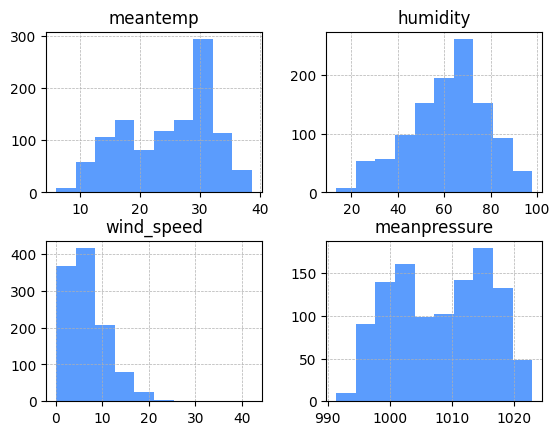

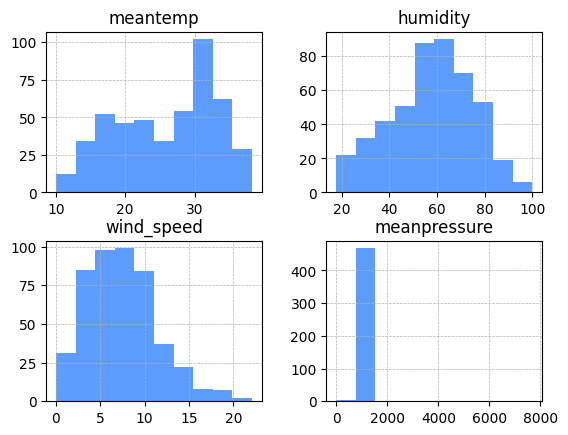

In [7]:
df_train.hist()
df_test.hist();

In [8]:
df_test['meanpressure'].describe()

count     473.000000
mean     1017.854414
std       316.789849
min        -3.041667
25%      1003.062500
50%      1009.312500
75%      1015.100000
max      7679.333333
Name: meanpressure, dtype: float64

There are outliers values within ```meanpressure``` field as typical atmospheric pressure values can range from approximately 950 hPa (in stormy, low pressure conditions) to 1085 hPa (in high pressure conditions). These are extremes and do not represent common situations. In most locations, atmospheric pressure is within a narrower range. Thus, in no case could the minimum and maximum values of df be reached (-3 hPa and 7679 hPa, respectively).

In [9]:
# Define the thresholds
pressure_lowthres, pressure_uppthres = 950, 1085

# Set to NaN outer values in treshold range and interpolate them
df_test.loc[(df_test['meanpressure'] < pressure_lowthres) | (df_test['meanpressure'] > pressure_uppthres), 'meanpressure'] = np.nan
df_test['meanpressure'] = df_test['meanpressure'].interpolate('linear')

In [10]:
# Display some basic metrics about the distribution of the series
df_train.describe().drop('count').style.background_gradient(cmap='Blues')

,meantemp,humidity,wind_speed,meanpressure
mean,24.904161,61.550379,6.656786,1008.348106
std,7.427251,16.795607,4.731354,7.640573
min,6.000000,13.428571,0.000000,991.375000
25%,18.196429,51.000000,3.237500,1001.500000
50%,27.000000,63.875000,5.866667,1009.000000
75%,30.937500,72.875000,9.025000,1015.267857
max,38.714286,98.000000,42.220000,1023.000000


Let's delve into the distribution of values within the ```wind_speed``` series. To accomplish this, the discrete data will be fitted to various well-established probability distributions. The objective is to identify the distribution that best captures the characteristics of the data. In this context, we opt for maximizing the log-likelihood as the key metric for model selection. The log-likelihood quantifies how well a given model explains the observed data, and maximizing it corresponds to enhancing the probability of observing the data under the chosen model. Given that we are comparing models with an equal number of parameters, alternatives such as the *Bayesian Information Criterion (BIC)* or *Akaike Information Criterion (AIC)*, which penalize model complexity, are not necessary in this specific scenario. Therefore, we focus on directly comparing the log-likelihood values, seeking the distribution that provides the highest log-likelihood as the most suitable model for describing the ```wind_speed``` data.

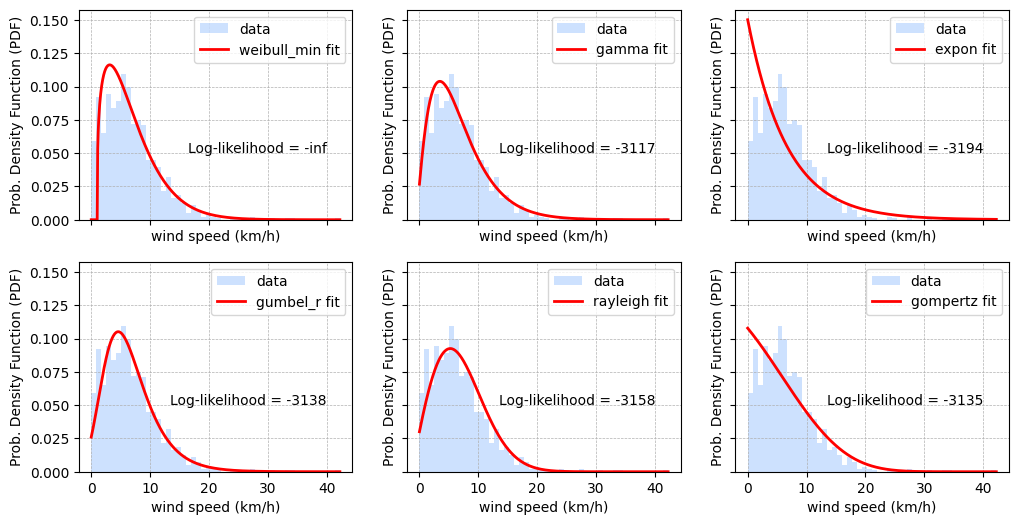

In [11]:
# Try different gaussian probability distributions
from scipy.stats import weibull_min, gumbel_r, gamma, rayleigh, expon, gompertz

# x values to fit
x = np.linspace(min(df_train['wind_speed']),
                max(df_train['wind_speed']), 500)

# List of probability distribution functions to test
prob_funs = [weibull_min, gumbel_r, gamma, rayleigh, expon, gompertz]

# Calculate the Log likelihood for each distribution
log_likelihood = {}

fig, ax = plt.subplots(2, 3, figsize=(12, 6), sharey=True, sharex=True)
for i, fun in enumerate(prob_funs):
    
    # Fit the data to estimate the parameters
    params = fun.fit(df_train['wind_speed'].array)
    
    # Log likelihood
    log_likelihood[fun.name] = fun.logpdf(df_train['wind_speed'].array, *params).sum()

    ax_ = ax[i % 2, i // 2]
    ax_.hist(df_train['wind_speed'], density=True, bins=50, alpha=.3, label='data')
    ax_.plot(x, fun.pdf(x, *params), 'r-', lw=2, label='{} fit'.format(fun.name))
    ax_.text(40, 0.05, 'Log-likelihood = %.0f' % log_likelihood[fun.name], ha='right')
    ax_.set_xlabel('wind speed (km/h)')
    ax_.set_ylabel('Prob. Density Function (PDF)')
    ax_.legend()

According to the log-likelihood values, the *Gamma* function is selected as the best distribution function for the ```wind_speed```.

The cumulative distribution function (CDF) of the Gamma distribution is defined as:

$F(x; \kappa, \theta) = \frac{1}{\Gamma(\kappa)} \gamma\left(\kappa, \frac{x}{\theta}\right)$

where $(\kappa)$ is the shape parameter, $(\theta)$ is the scale parameter, $(\Gamma(\kappa))$ is the gamma function, and $(\gamma(\kappa, x))$ is the regularized incomplete gamma function defined as:

$\gamma(\kappa, x) = \int_0^x t^{\kappa-1} e^{-t} \, dt $


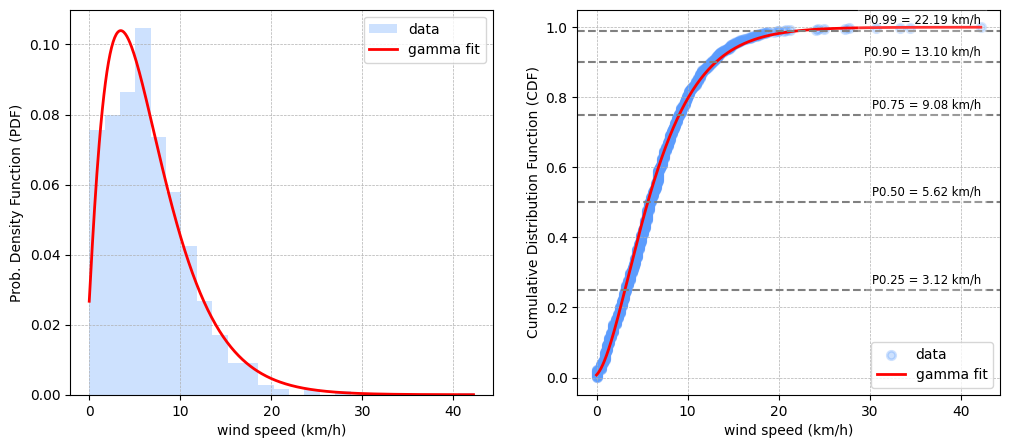

In [12]:
# x values to fit
x = np.linspace(min(df_train['wind_speed']),
                max(df_train['wind_speed']), 500)

# Fit the data to estimate the parameters
params = gamma.fit(df_train['wind_speed'].array)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
# PDF
ax[0].hist(df_train['wind_speed'], density=True, bins=25, alpha=.3, label='data')
ax[0].plot(x, gamma.pdf(x, *params), 'r-', lw=2, label='{} fit'.format(gamma.name))
ax[0].set_xlabel('wind speed (km/h)')
ax[0].set_ylabel('Prob. Density Function (PDF)')
ax[0].legend()

# CDF
ecdf = np.cumsum(np.ones_like(df_train['wind_speed'])) / len(df_train['wind_speed'])
ax[1].scatter(np.sort(df_train['wind_speed']), ecdf, lw=2, alpha=.3, label='data')
ax[1].plot(x, gamma.cdf(x, *params), 'r-', lw=2, label='{} fit'.format(gamma.name))

for ptile in [.25, .5, .75, .9, .99]:
    ax[1].axhline(ptile, ls='--', color='gray')
    ax[1].text(max(df_train['wind_speed']), ptile + 0.02, 'P%.2f = %.2f km/h' % (ptile, gamma.ppf(ptile, *params)),
               ha='right', fontsize='small', bbox=dict(facecolor='white', edgecolor='white', alpha=.2))

ax[1].set_xlabel('wind speed (km/h)'), ax[1].set_ylabel('Cumulative Distribution Function (CDF)')
ax[1].legend()

### Time series representation <a class="anchor" id="time-representation-header"></a>

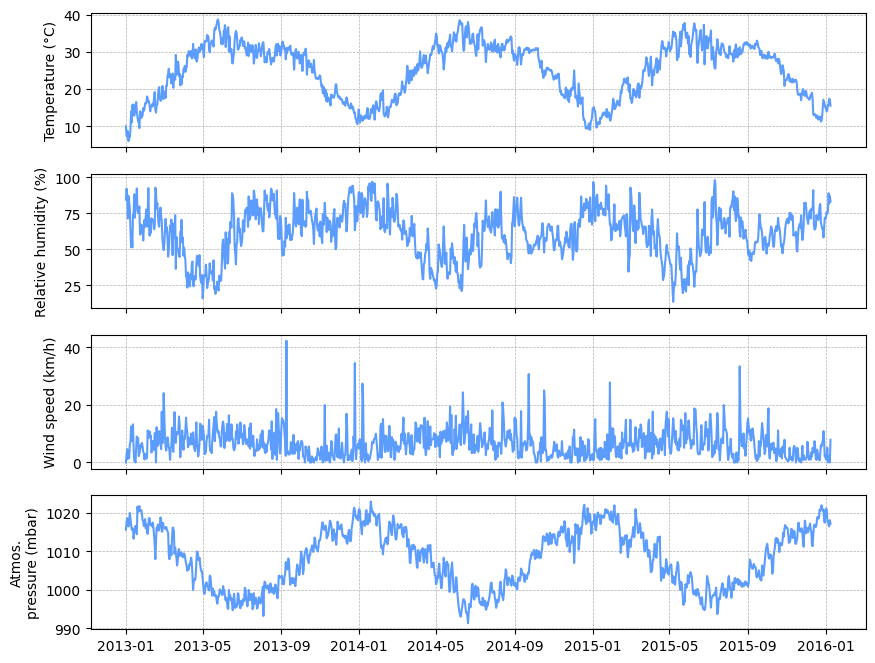

In [13]:
# Plot all time series
y_labels = ['Temperature (°C)', 'Relative humidity (%)', 'Wind speed (km/h)', 'Atmos.\npressure (mbar)']

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
for (i, col), label in zip(enumerate(df_train.columns), y_labels):
    ax[i].plot(df_train[col])
    ax[i].set_ylabel(label)
    if i == len(df_train.columns):
        ax[i].legend()

### Multivariate analysis <a class="anchor" id="multivariate-header"></a>

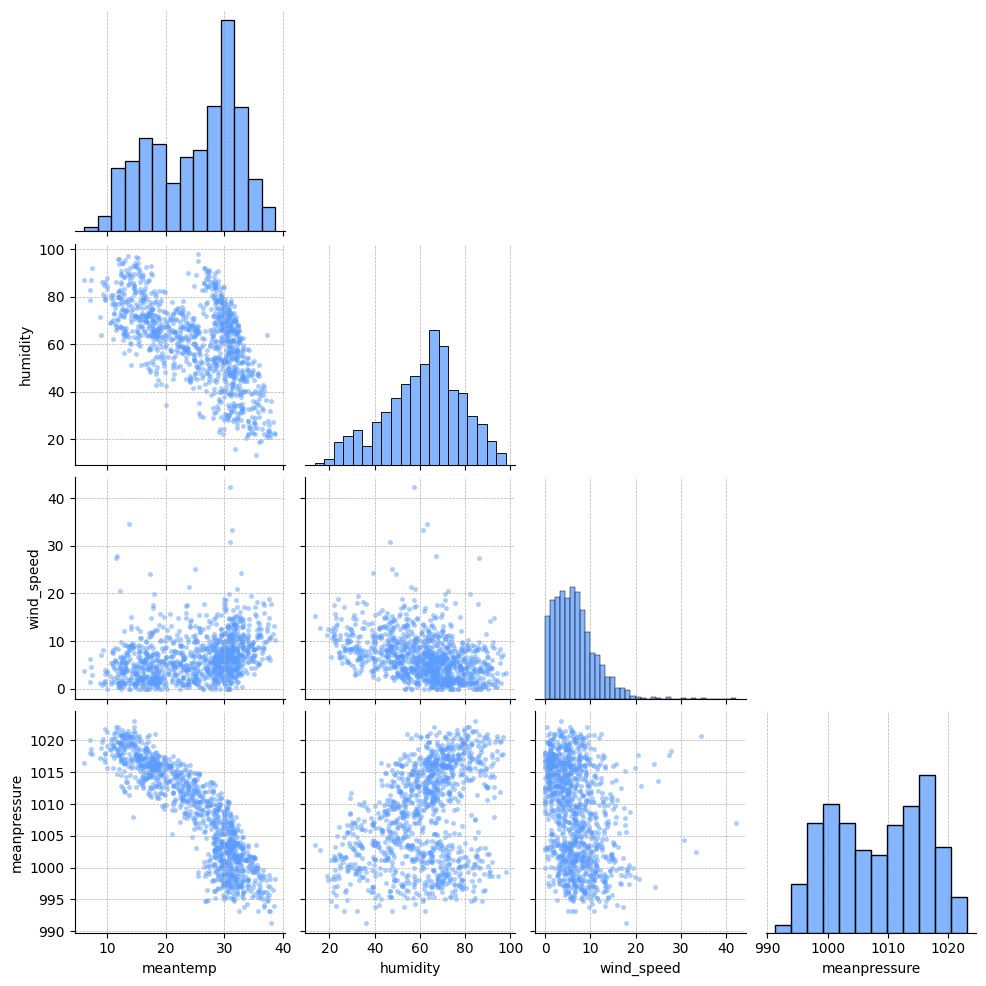

In [14]:
sns.pairplot(data=df_train, corner = True,
             plot_kws=dict(edgecolor=None, alpha=0.5, s=10))

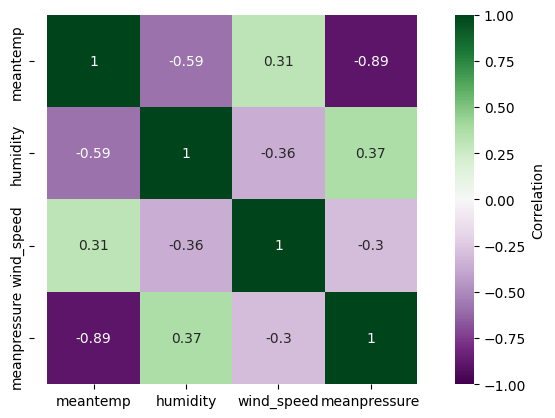

In [15]:
fig, ax = plt.subplots()
sns.heatmap(df_train.corr(),
            xticklabels=df_train.corr().columns,
            yticklabels=df_train.corr().columns,
            cmap='PRGn', center=0, vmin=-1, annot=True,
            cbar_kws={'label': 'Correlation'},
            ax=ax)
plt.grid()
plt.axis('equal');

## 2 - Time series analysis <a class="anchor" id="time-analysis-header"></a>

Time series can be made up of different components, which are listed below:
- **Trend (Linear and Non-Linear)**: The trend shows the general tendency of the data to increase or decrease during a long period of time.
- **Periodic fluctuations**:
  - **Seasonal variations**: These fluctuations refer to recurring patterns that consistently occur within a timeframe of less than a year. These patterns exhibit a uniform or nearly uniform repetition over a 12-month period. E.g.: climatic seasons (winter, spring, summer and fall).
  - **Cyclic variations**: These fluctuations refer to oscillatory movements that have a period of oscillation of more than a year. E.g.: Niño–Southern Oscillation (ENSO).
- **Random or Irregular movements**: These are the fluctuations that are not regular and are purely random or irregular. These variations are unforeseen, uncontrollable, unpredictable, and are erratic.

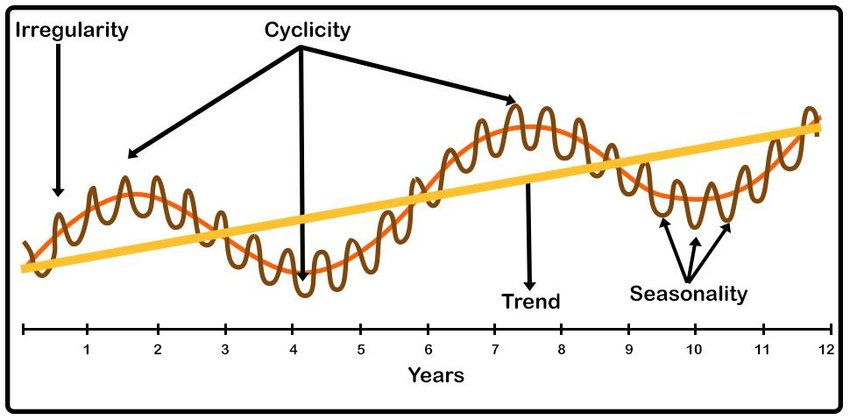

Image source: https://www.researchgate.net/figure/Time-Series-components-1-A-time-series-is-a-sequence-of-observations-measured-at_fig1_344658764

### Trend <a class="anchor" id="trend-header"></a>

#### Stationarity

The *Augmented Dickey-Fuller (ADF)* test is a key tool to assess unit roots in time series, indicating stationarity. ADF outcome guides decisions on applying some techniques to make the series stationary, ensuring accurate capturing of underlying patterns.

The *Kwiatkowski-Phillips-Schmidt-Shin (KPSS)* test, is a type of unit root test that tests for the stationarity of a given series around a deterministic trend. In other words, the test is somewhat similar in spirit to the ADF test. A common misconception, however, is that it can be used interchangeably with the ADF test. This can lead to misinterpretations about stationarity, which can easily go undetected, causing more problems down the line.

There could be a lot of confusion on when one should use the ADF test or KPSS test and which test would give a correct result. A better solution is to run both tests and makes sure that the series is truly stationary.

The following are the possible outcomes of applying both tests:

- <u>Case 1</u>: Both tests conclude that the given series is stationary –> The series is **stationary**.
- <u>Case 2</u>: Both tests conclude that the given series is non-stationary –> The series is **non-stationary**.
- <u>Case 3</u>: ADF concludes non-stationary, and KPSS concludes stationary –> The series is **trend stationary**. To make the series strictly stationary, the trend needs to be removed in this case. Then the detrended series is checked for stationarity.
- <u>Case 4</u>: ADF concludes stationary, and KPSS concludes non-stationary –> The series is **difference stationary**. Differencing is to be used to make series stationary. Then the differenced series is checked for stationarity.

Reference: https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/

In [16]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series: pd.Series, alpha = 0.05):
    """
    This funtion returns the interpretation of the results of ADF test for a given series.
    Args:
        - series (pd.Series): The data where the test will be performed.
        - alpha (float): The significance level of the test. Default is 0.05. This means that if the results of the test\
            are under the significance level, the test will determine that the series is stationary.
    """
    result = adfuller(series, autolag='AIC')
    print('\n- {}:'.format(series.name))
    print('ADF Statistic: %.3f' % result[0])
    print('p-value: %.3f' % result[1])
    if result[1] > alpha:
        print('We cannot reject the null hypothesis (the series is non-stationary).')
    else:
        print('We reject the null hypothesis (the series is stationary).')

print('ADF Test Results:')
for col in df_train.columns:
    adfuller_test(df_train[col])

ADF Test Results:

- meantemp:
ADF Statistic: -2.008
p-value: 0.283
We cannot reject the null hypothesis (the series is non-stationary).

- humidity:
ADF Statistic: -3.477
p-value: 0.009
We reject the null hypothesis (the series is stationary).

- wind_speed:
ADF Statistic: -3.871
p-value: 0.002
We reject the null hypothesis (the series is stationary).

- meanpressure:
ADF Statistic: -1.934
p-value: 0.316
We cannot reject the null hypothesis (the series is non-stationary).


In [17]:
from statsmodels.tsa.stattools import kpss

def kpss_test(series: pd.Series, alpha = 0.05):
    """
    This funtion returns the interpretation of the results of KPSS test for a given series.
    Args:
        - series (pd.Series): The data where the test will be performed.
        - alpha (float): The significance level of the test. Default is 0.05. This means that if the results of the test\
            are over the significance level, the test will determine that the series is stationary.
    """
    result = kpss(series)
    print('\n- {}:'.format(series.name))
    print('KPSS Statistic: %.3f' % result[0])
    print('p-value: %.3f' % result[1])
    if result[1] < alpha:
        print('We reject the null hypothesis (the series is non-stationary).')
    else:
        print('We reject the null hypothesis (the series is stationary).')

print('KPSS Test Results:')
for col in df_train.columns:
    kpss_test(df_train[col])

KPSS Test Results:

- meantemp:
KPSS Statistic: 0.157
p-value: 0.100
We reject the null hypothesis (the series is stationary).

- humidity:
KPSS Statistic: 0.114
p-value: 0.100
We reject the null hypothesis (the series is stationary).

- wind_speed:
KPSS Statistic: 0.432
p-value: 0.063
We reject the null hypothesis (the series is stationary).

- meanpressure:
KPSS Statistic: 0.171
p-value: 0.100
We reject the null hypothesis (the series is stationary).


According to the cases defined above, ```meantemp``` and ```meanpressure``` fields are *trend stationary*, whereas ```humidity``` and ```wind_speed``` are *stationary*.

### Periodic fluctuations <a class="anchor" id="periodic-header"></a>

#### Monthly box-plots

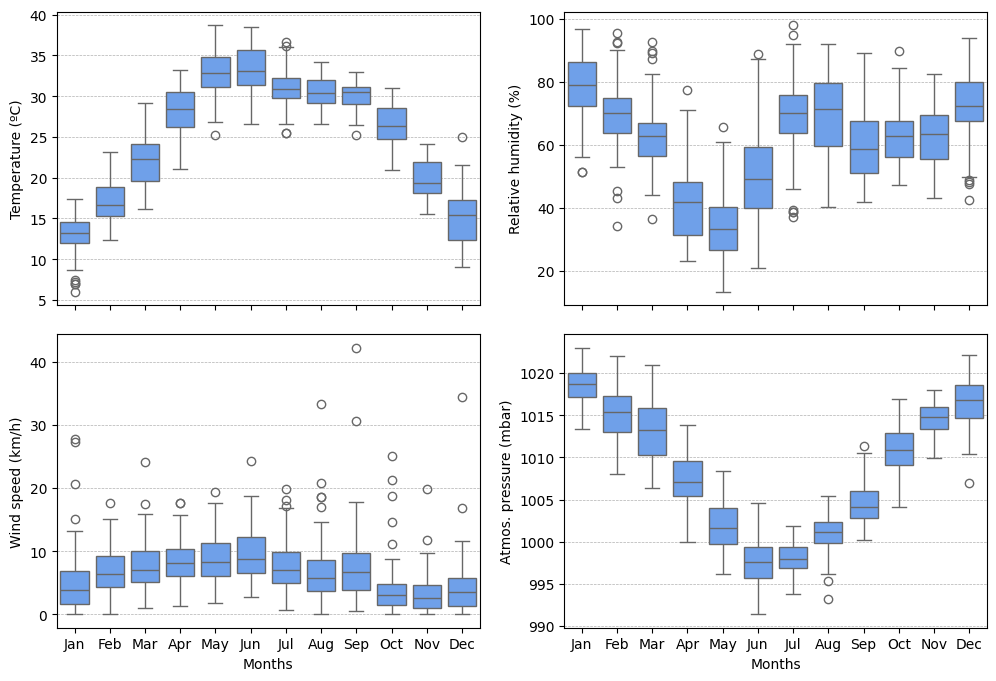

In [19]:
# Box plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
plt.subplot(2, 2, 1)
sns.boxplot(x=df_train.index.month, y=df_train['meantemp'])
plt.ylabel("Temperature (ºC)")

plt.subplot(2, 2, 2)
sns.boxplot(x=df_train.index.month, y=df_train['humidity'])
plt.ylabel("Relative humidity (%)")

plt.subplot(2, 2, 3)
sns.boxplot(x=df_train.index.month, y=df_train['wind_speed'])
plt.ylabel("Wind speed (km/h)"), plt.xlabel("Months")

plt.subplot(2, 2, 4)
sns.boxplot(x=df_train.index.month, y=df_train['meanpressure'])
plt.ylabel("Atmos. pressure (mbar)"), plt.xlabel("Months")

plt.xlabel("Months")
plt.xticks(np.arange(12), df_train.index.strftime('%b').unique())
plt.subplots_adjust(hspace=0.1)

#### Autocorrelation

Autocorrelation measures the degree of similarity between a time series and a lagged version of itself. Studying autocorrelation in atmospheric variables is valuable for identifying temporal patterns, such as recurring weather phenomena, which aids in forecasting and understanding climate dynamics.

Text(0.5, 0.98, 'Autocorrelation analysis')

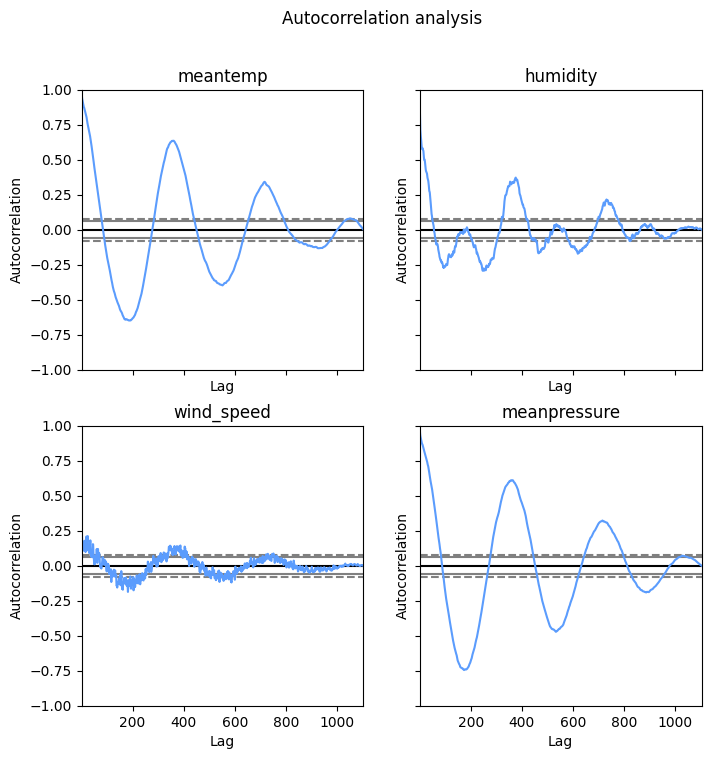

In [20]:
from pandas.plotting import autocorrelation_plot

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
for i, col in enumerate(df_train.columns):
    plt.subplot(2, 2, i + 1)
    autocorrelation_plot(df_train[col])
    plt.title(col)

plt.suptitle("Autocorrelation analysis")

As we can see in the above figure, ```meantemp``` and ```meanpressure``` have strong autocorrelation and seasonality (peaks every ~365 days). For ```wind_speed``` it has a regular but soft autocorrelation and a marked noise. The ```humidity``` has a medium autocorrelation and an irregular patttern.

#### Frequency-Domain analysis (Periodogram)

The periodogram is a key tool in spectral analysis of time series data, offering a visual and quantitative representation of energy distribution across various frequencies within the signal.
The periodogram highlights the relative contributions of different periodic components in the time series. This decomposition is crucial for identifying trends, seasonal patterns, and cyclic phenomena, providing deeper insights into the underlying temporal structure of the data.

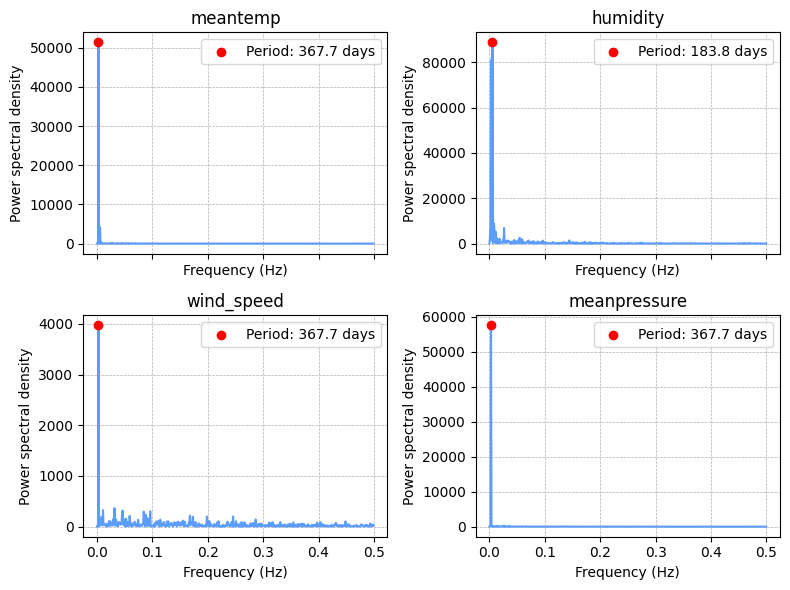

In [21]:
from scipy.signal import periodogram

fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True)

for i, col in enumerate(df_train.columns):
    # Get both frequencies and Power Spectral Density
    freq, power = periodogram(df_train[col])

    # Get the period of max power
    period = 1 / freq[np.argmax(power)]

    plt.subplot(2, 2, i + 1)
    plt.plot(freq, power)
    plt.scatter(freq[np.argmax(power)], max(power), marker='o', color='red', zorder=2, label='Period: %.1f days' % period)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power spectral density')
    plt.legend()
    plt.title(col)

plt.tight_layout()

With the periodograms we identified and quantified which is the oscillation pattern that has more energy. The results have shown how all series have a seasonal pattern in ~365-day frequency, except for ```humidity``` that has a 183-day frequency.

#### Decomposition

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

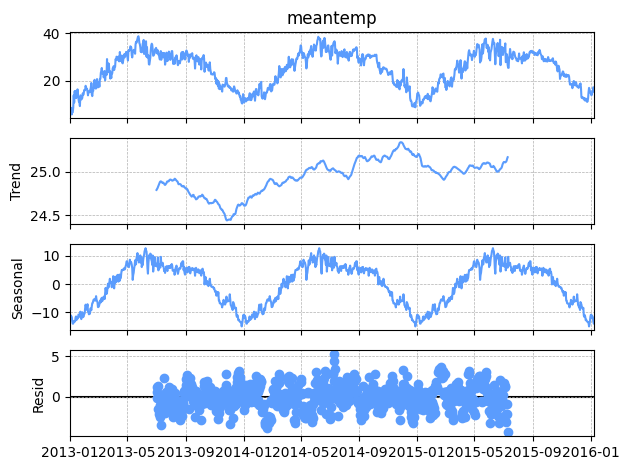

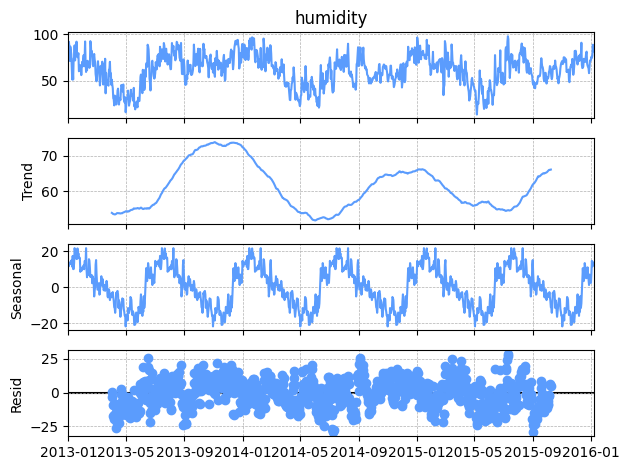

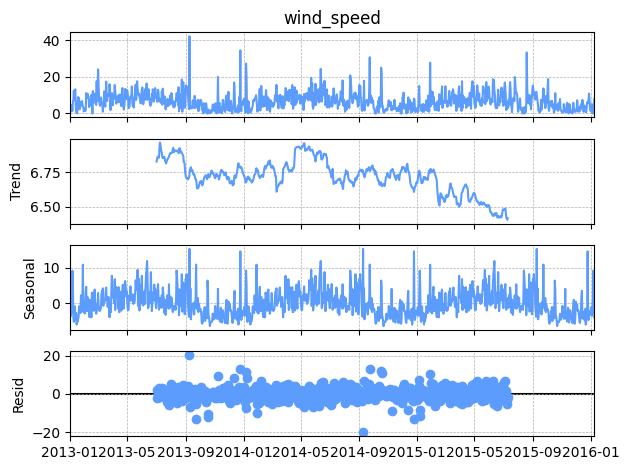

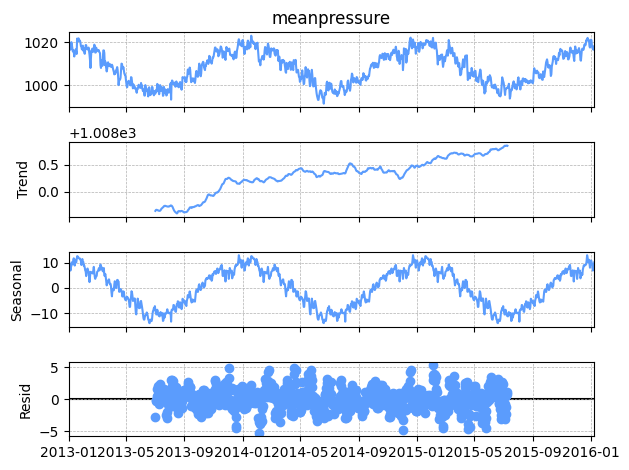

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposition
for col in df_train.columns:
    if col == 'humidity':
        decomp = seasonal_decompose(df_train[col], model='additive', period=183).plot() # The seasonal frequency revealed in spectral analysis
    else:
        decomp = seasonal_decompose(df_train[col], model='additive', period=365).plot() # The seasonal frequency revealed in spectral analysis

## 3 - Modelling <a class="anchor" id="modelling-header"></a>

### Prepare the data via pipeline <a class="anchor" id="prepare-data-header"></a>

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom transformer to select specific columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    '''select specific columns'''
    def __init__(self, subset, target):
        self.subset = subset
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Add a lagged version of target variable as a predictor
        X[target + '_lag3'] = X[target].shift(periods=3).fillna(0)
        return X.loc[:, self.subset + [target + '_lag3']]

# Custom transformer to add time-related columns
class AddTimeColumns(BaseEstimator, TransformerMixin):
    '''add time columns''' 
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X['DayOfYear'] = X.index.dayofyear
        X['Week'] = X.index.isocalendar().week.astype(int)
        X['Month'] = X.index.month
        #X['Quarter'] = X.index.quarter

        return X

# Custom transformer to convert NumPy array to DataFrame
class DataFrameTransformer(BaseEstimator, TransformerMixin):
    '''converts NumPy array to DataFrame'''
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(X, columns=self.columns)

# Set the name of the target variable
target = 'meantemp'

# Select the other columns to perform a multivariate analysis, otherwise just define an empty list
features = ['humidity', 'wind_speed', 'meanpressure']
#features = []

# Create a pipeline with custom transformers
pipeline = Pipeline([
    ('select_columns', ColumnSelector(features, target)),
    ('add_time_columns', AddTimeColumns()),
    ('scale_data', MinMaxScaler()),
    ('to_dataframe', DataFrameTransformer(columns=features + [target + '_lag3', 'DayOfYear', 'Week', 'Month']))
])

# Define target variables for training and testing
y_train, y_test = df_train[target], df_test[target]

# Apply the pipeline to the training and testing data
X_train = pipeline.fit_transform(df_train)
X_test = pipeline.transform(df_test)

In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a function to plot the prediction of the different models that will be tested
def plot_prediction(model, df_train, df_test, X_train, X_test, y_train, y_test):
    df_train = df_train.copy()
    df_test = df_test.copy()

    X_full = pd.concat([df_train, df_test])
    X_full = pipeline.transform(X_full)

    if isinstance(model, keras.Sequential): # LSTM model
        # Reshape X_full and X_test to make it compatible with LSTM input        
        X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        y_full_pred = model.predict(X_full, verbose=0).astype(float).reshape(-1)
        y_train_pred = model.predict(X_train, verbose=0).astype(float).reshape(-1)
        y_test_pred = model.predict(X_test, verbose=0).astype(float).reshape(-1)

    elif isinstance(model, SARIMAXResultsWrapper): # SARIMA model
        # Group by months
        df_train = df_train.groupby(pd.Grouper(freq='30D')).mean()
        df_test = df_test.groupby(pd.Grouper(freq='30D')).mean()
        y_train = y_train.groupby(pd.Grouper(freq='30D')).mean()
        y_test = y_test.groupby(pd.Grouper(freq='30D')).mean()

        y_train_pred = model.get_prediction(start=y_train.index[0], end=y_train.index[-1]).predicted_mean
        y_test_pred = model.get_forecast(steps=len(y_test)).predicted_mean
        y_full_pred = pd.concat([y_train_pred, y_test_pred])

    else: # Any ML models
        y_full_pred = model.predict(X_full).astype(float)
        y_train_pred = model.predict(X_train).astype(float)
        y_test_pred = model.predict(X_test).astype(float)

    # Calculate residuals
    residuals = y_test - y_test_pred

    # Calculate confidence bounds
    std_dev_residuals = np.std(residuals)
    lower_bound = y_test_pred - 1.96 * std_dev_residuals
    upper_bound = y_test_pred + 1.96 * std_dev_residuals

    # Plot the predictions
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(pd.concat([df_train, df_test]).index, pd.concat([y_train, y_test]), marker='o', s=10, label='Actual Data')
    ax.plot(pd.concat([df_train, df_test]).index, y_full_pred, color='#FECB31', label='Predicted Data')
    ax.fill_between(df_test.index, lower_bound, upper_bound, color='#FECB31', alpha=0.3)
    ax.text(df_train.index[int(len(df_train) / 2)], min(y_full_pred),
            'TRAIN SET\nMAE=%.2f' % mean_absolute_error(y_train_pred, y_train), ha='center', style='italic')
    ax.text(df_test.index[int(len(df_test) / 2)], min(y_full_pred),
            'TEST SET\nMAE=%.2f' % mean_absolute_error(y_test_pred, y_test), ha='center', style='italic')
    ax.set_xlabel('Time'), ax.set_ylabel(target)
    ax.axvline(df_train.index[-1], ls='--', color='gray')
    ax.legend(loc='upper left')

    fig, ax = plt.subplots()
    ax.scatter(y_train, y_train_pred, alpha=.5, label='Train set (RMSE=%.2f\nR2=%.2f)' % (mean_squared_error(y_train, y_train_pred), r2_score(y_train, y_train_pred)))
    ax.scatter(y_test, y_test_pred, alpha=.5, label='Test set (RMSE=%.2f\nR2=%.2f)' % (mean_squared_error(y_test, y_test_pred), r2_score(y_test, y_test_pred)))
    ax.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], ls='--', color='red')
    ax.set_xlabel('Actual values'), ax.set_ylabel('Predicted values')
    ax.set_xlim([min(y_train), max(y_train)]), ax.set_ylim([min(y_train), max(y_train)])
    #ax.axis('square')
    ax.legend()

### Machine Learning <a class="anchor" id="ML-header"></a>

Let's try different ML models. Select the one that works best by default and fine-tune it for best performance.

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Set the number of folds
tscv = TimeSeriesSplit(n_splits=10)

# Create a list with the models names that we are going to perform
models = [
    LinearRegression(),
    ElasticNet(),
    SVR(),
    RandomForestRegressor(random_state=42),
    KNeighborsRegressor(),
    XGBRegressor(random_state=42),
    CatBoostRegressor(random_state=42, silent=True),
]

# Check the accuracy of the models
for model in models:
    acc = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_error', verbose=0)
    print(f'{type(model).__name__} - mean MAE: {-acc.mean():.2f} +/- {acc.std():.2f}')

LinearRegression - mean MAE: 2.25 +/- 1.11
ElasticNet - mean MAE: 6.74 +/- 3.00
SVR - mean MAE: 2.39 +/- 2.34
RandomForestRegressor - mean MAE: 2.09 +/- 1.33
KNeighborsRegressor - mean MAE: 2.10 +/- 1.35
XGBRegressor - mean MAE: 2.21 +/- 1.53
CatBoostRegressor - mean MAE: 2.07 +/- 1.59


In [26]:
from sklearn.model_selection import GridSearchCV

# Fine-tune the selected model
model = RandomForestRegressor(random_state=42)

# Hyperparameter definition
params = {
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'absolute_error'],
    'max_depth': [10, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

"""
- n_estimators: The number of trees in the forest. It specifies how many decision tree classifiers are used in the ensemble.
- criterion: The function to measure the quality of a split. 'gini' uses the Gini impurity, while 'absolute_error' uses the absolute error.
- max_depth: It is the maximum depth of each decision tree. It controls the complexity of the model as each tree is expanded until this depth is reached.
- min_samples_split: The minimum number of samples required to split an internal node.
- min_samples_leaf: The minimum number of samples required to be at a leaf node.
"""

# Fit the hyperparameters by using GridSearchCV
model = GridSearchCV(model, params, cv=tscv, n_jobs=-1,
                     scoring='neg_mean_absolute_error');
model.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'absolute_error'],
                         'max_depth': [10, 20, 25],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200]},
             scoring='neg_mean_absolute_error')

Text(0.5, 1.0, 'Prediction using Random Forest')

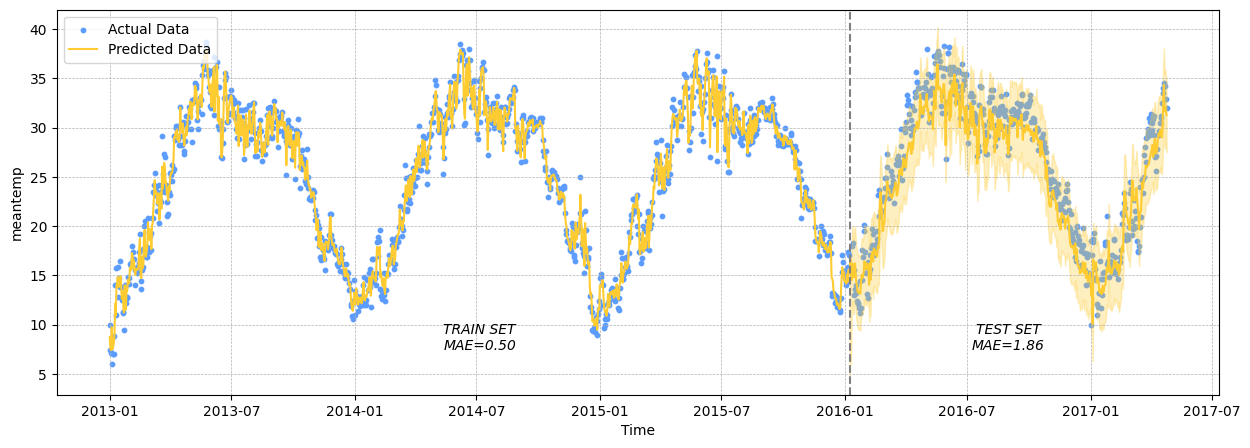

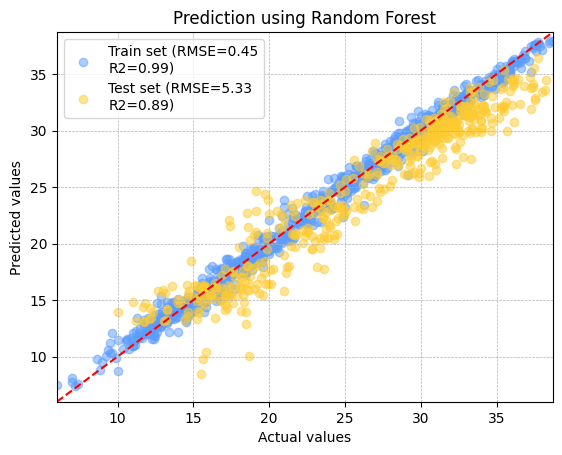

In [27]:
modelRF = model
plot_prediction(modelRF, df_train, df_test, X_train, X_test, y_train, y_test)
plt.title('Prediction using Random Forest')

### Deep Learning <a class="anchor" id="DL-header"></a>

We are going to test slightly more complex models. The main approach is to test performance using LSTM neural networks and a combination of CNN+LSTM.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

keras.backend.clear_session()

# Reshape X_train to make it compatible with LSTM input
X_train_nn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
input_shape = (X_train.shape[1], 1)

# Create the LSTM model
model = Sequential([
    LSTM(units=100, activation='relu', return_sequences=True, input_shape=input_shape),
    LSTM(units=100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    LSTM(units=100, activation='relu',  return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    LSTM(units=100, activation='relu',  return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu'),
    Dense(units=1)
    ])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 100)            80400     
                                                                 
 lstm_3 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_4 (LSTM)               (None, 7, 100)            

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model
history = model.fit(X_train_nn, y_train, epochs=250, batch_size=32, validation_split=0.15, verbose=0)

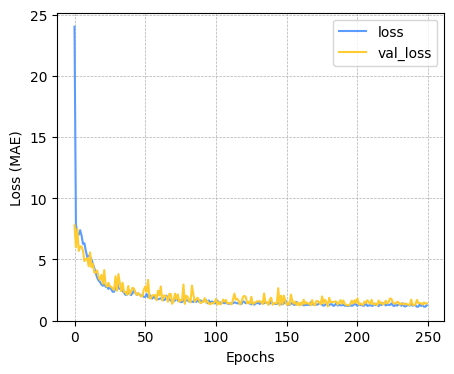

In [30]:
# Plot the loss over the epochs
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(5, 4))
plt.xlabel("Epochs"), plt.ylabel("Loss (MAE)")
plt.grid(True)

Text(0.5, 1.0, 'Prediction using LSTM')

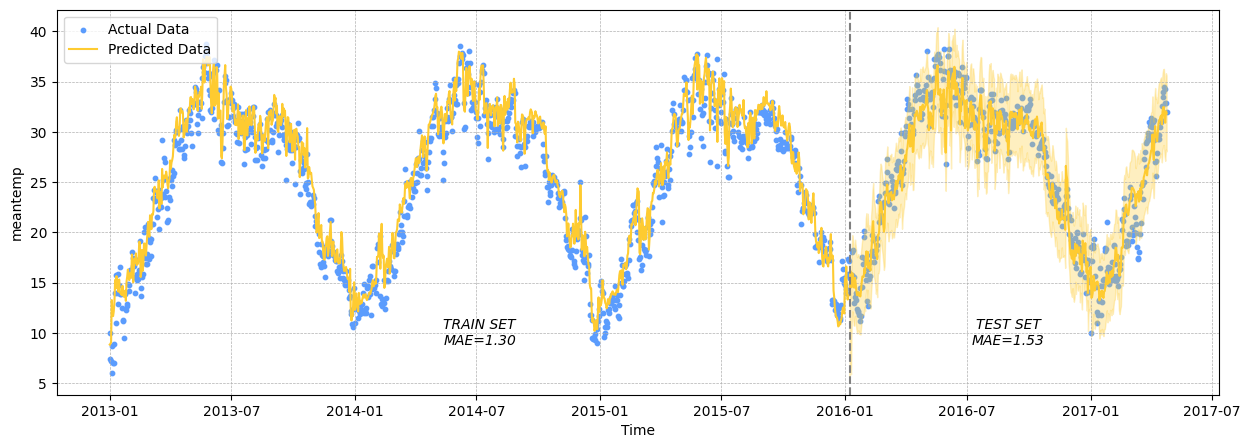

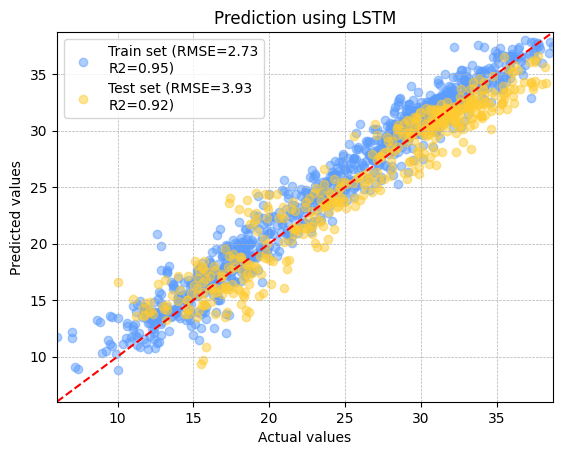

In [31]:
modelLSTM = model
plot_prediction(modelLSTM, df_train, df_test, X_train, X_test, y_train, y_test)
plt.title('Prediction using LSTM')

CNN + LSTM

In [32]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

keras.backend.clear_session()

input_shape = (X_train.shape[1], 1)

# Create the LSTM + CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    MaxPooling1D(pool_size=2),
    LSTM(units=100, activation='relu', return_sequences=True),
    LSTM(units=100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    LSTM(units=100, activation='relu',  return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu', return_sequences=True),
    LSTM(units=100, activation='relu',  return_sequences=True),
    Dropout(0.2),
    LSTM(units=100, activation='relu'),
    Dense(units=1)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 2, 64)             0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 2, 100)            66000     
                                                                 
 lstm_1 (LSTM)               (None, 2, 100)            80400     
                                                                 
 dropout (Dropout)           (None, 2, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 2, 100)            80400     
                                                       

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Fit the model
history = model.fit(X_train_nn, y_train, epochs=250, batch_size=32, validation_split=0.15, verbose=0)

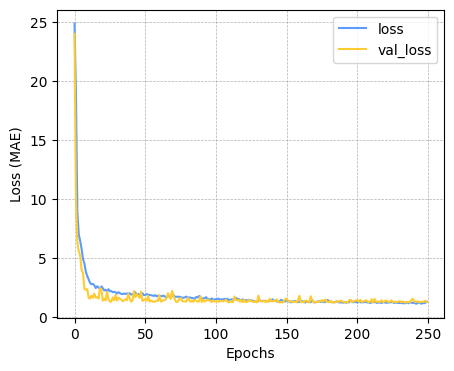

In [34]:
# Plot the loss over the epochs
pd.DataFrame(history.history)[['loss','val_loss']].plot(figsize=(5, 4))
plt.xlabel("Epochs"), plt.ylabel("Loss (MAE)")
plt.grid(True)

Text(0.5, 1.0, 'Prediction using CNN+LSTM')

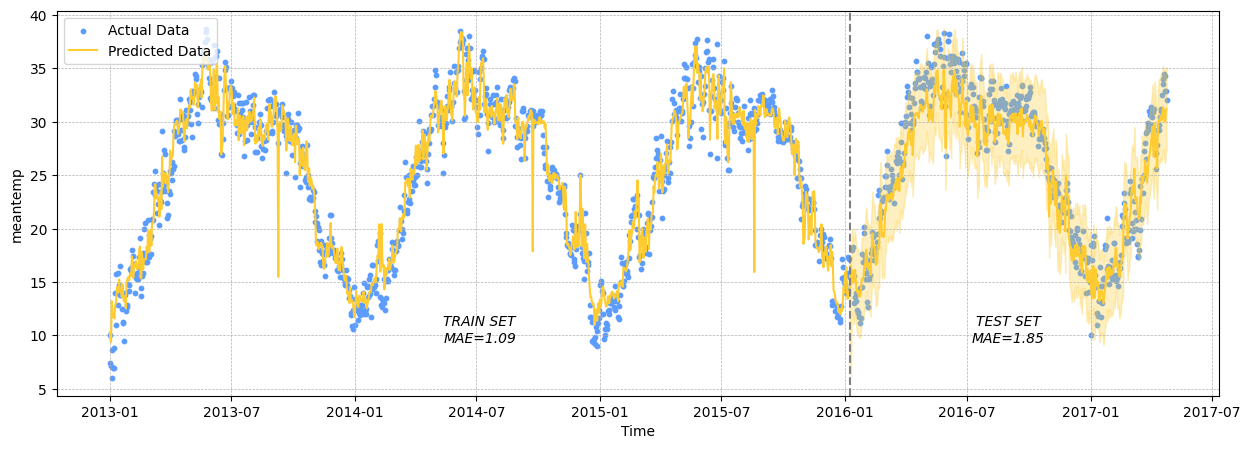

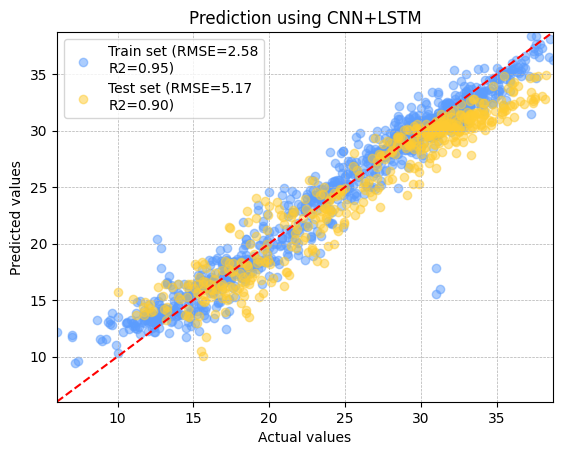

In [35]:
modelCNNLSTM = model
plot_prediction(modelCNNLSTM, df_train, df_test, X_train, X_test, y_train, y_test)
plt.title('Prediction using CNN+LSTM')

### ARIMA <a class="anchor" id="ARIMA-header"></a>

The Seasonal Autoregressive Integrated Moving Average (SARIMA) model is a time series forecasting method that combines autoregressive, differencing, moving average, and seasonal components to capture and predict patterns in data with seasonality. The SARIMA model is characterized by several parameters: *p, d, q, P, D, Q, s*.

- p : non-seasonal AR order
- d : non-seasonal differencing order
- q : non-seasonal MA order
- P : seasonal AR order
- D : seasonal differencing order
- Q : seasonal MA order
- s : seasonal period length

In [36]:
# Group the data by months as the ARIMA model is computationally very demanding
y_train_monthly = y_train.groupby(pd.Grouper(freq='30D')).mean()
y_test_monthly = y_test.groupby(pd.Grouper(freq='30D')).mean()

# Select the best model
best_arima = pm.auto_arima(y_train_monthly,
                           error_action='ignore',
                           trace=False,
                           suppress_warnings=True,
                           maxiter=500,
                           m=12,
                           seasonal=True)
print(best_arima.params)

<bound method ARIMA.params of ARIMA(maxiter=500, order=(3, 0, 1), scoring_args={},
      seasonal_order=(2, 0, 0, 12), suppress_warnings=True)>


In [37]:
# Define the model and fit it (the order and seasonal order are parameteres that are supposed to be fine-tuned with pmdarima.arima.auto_arima, but the computation time was exceeded)
model = SARIMAX(y_train_monthly, order=(3, 0, 1), seasonal_order=(2, 0, 0, 12))
model = model.fit()

Text(0.5, 1.0, 'Prediction using SARIMA')

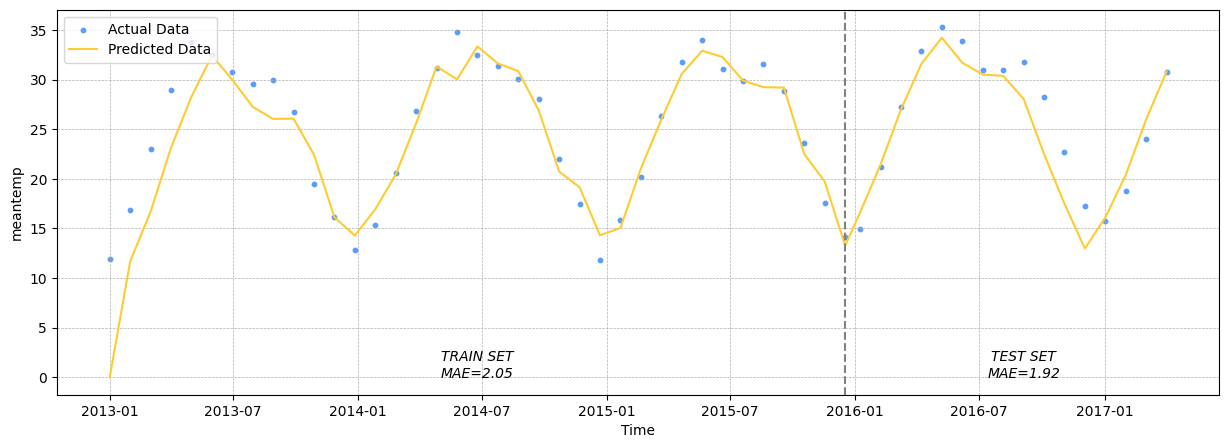

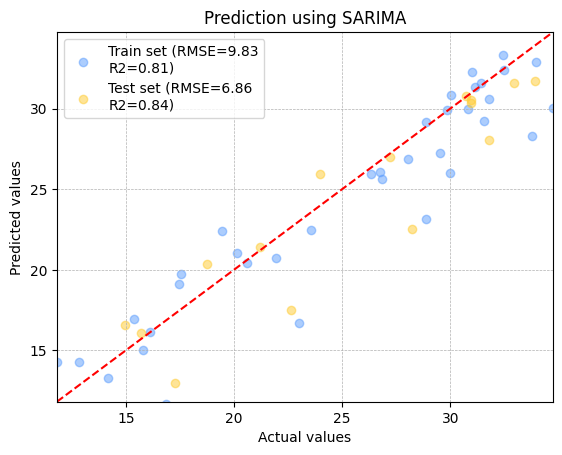

In [38]:
modelSARIMA = model
plot_prediction(modelSARIMA, df_train, df_test, X_train, X_test, y_train, y_test)
plt.title('Prediction using SARIMA')

### Check the results for all the models <a class="anchor" id="check-results-header"></a>

In [39]:
# Create an empty DataFrame to fill in with the metrics of each model performances
model_results = pd.DataFrame(index=["Random Forest", "LSTM", "CNN+LSTM", "SARIMA"])

for idx, model in zip(model_results.index, [modelRF, modelLSTM, modelCNNLSTM, modelSARIMA]):
    # Prepare the predictions for each model
    if idx == "Random Forest":
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
    elif idx in ['LSTM', 'CNN+LSTM']:
        y_train_pred = model.predict(X_train_nn)
        y_test_pred = model.predict(np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)))
    else:
        y_train_pred = model.get_prediction(start=y_train_monthly.index[0], end=y_train_monthly.index[-1]).predicted_mean
        y_test_pred = model.get_forecast(steps=len(y_test_monthly)).predicted_mean
        y_train = y_train.groupby(pd.Grouper(freq='30D')).mean()
        y_test = y_test.groupby(pd.Grouper(freq='30D')).mean()

    # Add the results as new columns
    model_results.loc[idx, 'Train R2'] = r2_score(y_train, y_train_pred)
    model_results.loc[idx, 'Train MAE'] = mean_absolute_error(y_train, y_train_pred)
    model_results.loc[idx, 'Train RMSE'] = mean_squared_error(y_train, y_train_pred)

    model_results.loc[idx, 'Test R2'] = r2_score(y_test, y_test_pred)
    model_results.loc[idx, 'Test MAE'] = mean_absolute_error(y_test, y_test_pred)
    model_results.loc[idx, 'Test RMSE'] = mean_squared_error(y_test, y_test_pred)

model_results.head()

15/15 [==============================] - 0s 3ms/step


,Train R2,Train MAE,Train RMSE,Test R2,Test MAE,Test RMSE
Random Forest,0.991892,0.498219,0.446876,0.894129,1.855122,5.330872
LSTM,0.950502,1.299355,2.728056,0.921915,1.525665,3.931773
CNN+LSTM,0.953181,1.093799,2.580389,0.897312,1.849067,5.170567
SARIMA,0.806197,2.048375,9.830688,0.843578,1.917881,6.864468


According to the test set results, the ```LSTM``` model is the best for the three metrics evaluated (R2, MAE and RMSE). In addition, it is the model with the least overfitting (the difference between the train and test set is the smallest).